## NLP Project - SemEval2023 Task 3 subtask 1 - Detecting the category in online news in a multi-lingual setup

##### Import libraries

In [36]:
from st1 import make_dataframe
import helper_functions as hf 
import pandas as pd

## Language - English

### Part 1 - Analyze and process data

#### Analyze data

##### Load data

In [37]:
train_folder = "data/en/train-articles-subtask-1/"
train_labels = "data/en/train-labels-subtask-1.txt"

test_folder = "data/en/dev-articles-subtask-1/"

In [38]:
df_train = make_dataframe(train_folder, train_labels)
df_test = make_dataframe(test_folder, labels_folder = None)

433it [00:00, 5280.58it/s]
83it [00:00, 4882.43it/s]


In [39]:
df_train.head()

,text,type
id,,
833042063,Chelsea Handler Admits She’s ‘Very Sexually At...,satire
832959523,How Theresa May Botched\n\nThose were the time...,satire
833039623,Robert Mueller III Rests His Case—Dems NEVER W...,satire
833032367,Robert Mueller Not Recommending Any More Indic...,satire
814777937,The Far Right Is Trying to Co-opt the Yellow V...,satire


In [40]:
df_test.head()

,text
id,
813452859,EU Profits From Trading With UK While London L...
813494037,Sadiq Khan Slammed for Pro-EU 'Message of Supp...
813547724,Foreign Secretary Jeremy Hunt says the UK shou...
813552066,"You insult us, ambassador: Woody Johnson flagr..."
813601978,Big Apple joins in ringing in New Year after r...


##### check data characteristics

Total number of samples:
text    433
type    433
dtype: int64

class distribution:
type
opinion      382
reporting     41
satire        10
Name: type, dtype: int64

 class distribution in %:
type
opinion      0.88
reporting    0.09
satire       0.02
Name: type, dtype: float64


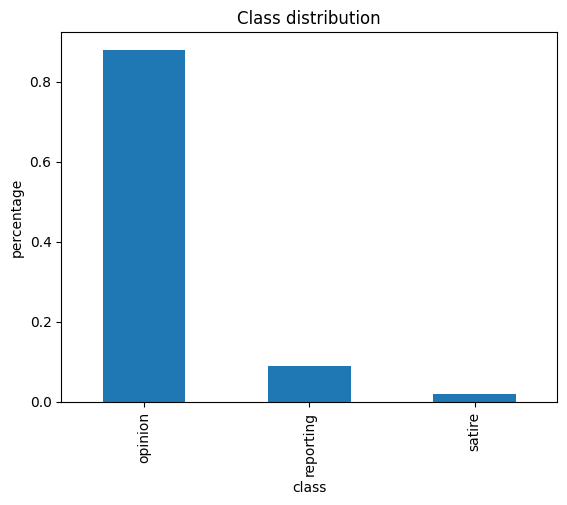

In [41]:
hf.class_distr(class_col="type", df = df_train)

In [42]:
words_per_sample_train = hf.words_per_sample(df_train["text"]) 
words_per_sample_test = hf.words_per_sample(df_test["text"]) 
print(f"\n Median number of words per sample in train set: {words_per_sample_train}")
print(f"\n Median number of words per sample in test set: {words_per_sample_test}")


 Median number of words per sample in train set: 685.0

 Median number of words per sample in test set: 695.0


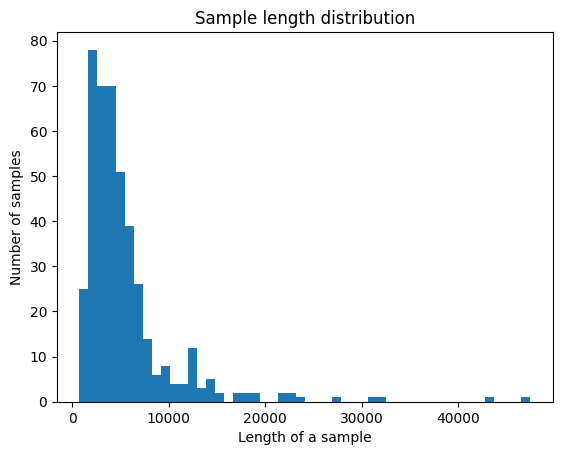

In [43]:
hf.plot_sample_length_distr(df_train["text"])

In [44]:
num_samples_train = df_train.count().values[0]
num_samples_test = df_test.count().values[0]

train_ratio =  num_samples_train/words_per_sample_train
test_ratio = num_samples_test/ words_per_sample_test
print(train_ratio)
print(test_ratio)

0.6321167883211679
0.11942446043165468


#### Process data

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#### Clean special characters and whitespaces

In [46]:
df_list =  [df_train, df_test]

for df in df_list:

    white_spaces = ["\r", "\n","\t", "    "]
    punctuation_signs = list("?:!.,;")

    df['text_clean_1'] = df['text']

    # whitespaces
    for char in white_spaces:
        df['text_clean_1'] = df['text_clean_1'].str.replace(char, " ")

    # quotation marks
    df['text_clean_1'] = df['text_clean_1'].str.replace('"', '')


    # puncuation signs
    for sign in punctuation_signs:
        df['text_clean_1'] = df['text_clean_1'].str.replace(sign, '')

C:\Users\kasia\AppData\Local\Temp\ipykernel_3852\1733778788.py:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['text_clean_1'] = df['text_clean_1'].str.replace(sign, '')
C:\Users\kasia\AppData\Local\Temp\ipykernel_3852\1733778788.py:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['text_clean_1'] = df['text_clean_1'].str.replace(sign, '')


In [47]:
df_test.head()
df_train.head()

,text,type,text_clean_1
id,,,
833042063,Chelsea Handler Admits She’s ‘Very Sexually At...,satire,Chelsea Handler Admits She’s ‘Very Sexually At...
832959523,How Theresa May Botched\n\nThose were the time...,satire,How Theresa May Botched Those were the times…...
833039623,Robert Mueller III Rests His Case—Dems NEVER W...,satire,Robert Mueller III Rests His Case—Dems NEVER W...
833032367,Robert Mueller Not Recommending Any More Indic...,satire,Robert Mueller Not Recommending Any More Indic...
814777937,The Far Right Is Trying to Co-opt the Yellow V...,satire,The Far Right Is Trying to Co-opt the Yellow V...


#### Make all lowercase

In [48]:
for df in df_list:
    df['text_clean_2'] = df['text_clean_1'].str.lower()

In [49]:
df_train.head()

,text,type,text_clean_1,text_clean_2
id,,,,
833042063,Chelsea Handler Admits She’s ‘Very Sexually At...,satire,Chelsea Handler Admits She’s ‘Very Sexually At...,chelsea handler admits she’s ‘very sexually at...
832959523,How Theresa May Botched\n\nThose were the time...,satire,How Theresa May Botched Those were the times…...,how theresa may botched those were the times…...
833039623,Robert Mueller III Rests His Case—Dems NEVER W...,satire,Robert Mueller III Rests His Case—Dems NEVER W...,robert mueller iii rests his case—dems never w...
833032367,Robert Mueller Not Recommending Any More Indic...,satire,Robert Mueller Not Recommending Any More Indic...,robert mueller not recommending any more indic...
814777937,The Far Right Is Trying to Co-opt the Yellow V...,satire,The Far Right Is Trying to Co-opt the Yellow V...,the far right is trying to co-opt the yellow v...


#### Remove 's

In [50]:
for df in df_list:
    df['text_clean_3'] = df['text_clean_2'].str.replace("'", "")
    df['text_clean_3'] = df['text_clean_3'].str.replace("‘", "")
    df['text_clean_3'] = df['text_clean_3'].str.replace("’s", "")

In [51]:
df_train.head()

,text,type,text_clean_1,text_clean_2,text_clean_3
id,,,,,
833042063,Chelsea Handler Admits She’s ‘Very Sexually At...,satire,Chelsea Handler Admits She’s ‘Very Sexually At...,chelsea handler admits she’s ‘very sexually at...,chelsea handler admits she very sexually attra...
832959523,How Theresa May Botched\n\nThose were the time...,satire,How Theresa May Botched Those were the times…...,how theresa may botched those were the times…...,how theresa may botched those were the times…...
833039623,Robert Mueller III Rests His Case—Dems NEVER W...,satire,Robert Mueller III Rests His Case—Dems NEVER W...,robert mueller iii rests his case—dems never w...,robert mueller iii rests his case—dems never w...
833032367,Robert Mueller Not Recommending Any More Indic...,satire,Robert Mueller Not Recommending Any More Indic...,robert mueller not recommending any more indic...,robert mueller not recommending any more indic...
814777937,The Far Right Is Trying to Co-opt the Yellow V...,satire,The Far Right Is Trying to Co-opt the Yellow V...,the far right is trying to co-opt the yellow v...,the far right is trying to co-opt the yellow v...


#### Remove stop words and lemmatize

In [52]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [53]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

print(stop_words[0:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kasia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kasia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kasia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [55]:
lemmatizer = WordNetLemmatizer()

In [56]:
for df in df_list:
    df['text_clean_4'] = df['text_clean_3']

    lemmatized_texts = []

    for row in df['text_clean_4']:
        text = row
        word_tokens = text.split(" ")

        lemmas  = []
        lemmatized_text = []

        for word in word_tokens:
            if word not in stop_words:
                lemmas.append(lemmatizer.lemmatize(word, pos = 'v'))

        lemmatized_text = " ".join(lemmas)

        lemmatized_texts.append(lemmatized_text)
        
    df['text_clean_4']= lemmatized_texts


In [57]:
df_train.head()

,text,type,text_clean_1,text_clean_2,text_clean_3,text_clean_4
id,,,,,,
833042063,Chelsea Handler Admits She’s ‘Very Sexually At...,satire,Chelsea Handler Admits She’s ‘Very Sexually At...,chelsea handler admits she’s ‘very sexually at...,chelsea handler admits she very sexually attra...,chelsea handler admit sexually attract robert ...
832959523,How Theresa May Botched\n\nThose were the time...,satire,How Theresa May Botched Those were the times…...,how theresa may botched those were the times…...,how theresa may botched those were the times…...,theresa may botch times… time page 1 january ...
833039623,Robert Mueller III Rests His Case—Dems NEVER W...,satire,Robert Mueller III Rests His Case—Dems NEVER W...,robert mueller iii rests his case—dems never w...,robert mueller iii rests his case—dems never w...,robert mueller iii rest case—dems never carlo...
833032367,Robert Mueller Not Recommending Any More Indic...,satire,Robert Mueller Not Recommending Any More Indic...,robert mueller not recommending any more indic...,robert mueller not recommending any more indic...,robert mueller recommend indictments course m...
814777937,The Far Right Is Trying to Co-opt the Yellow V...,satire,The Far Right Is Trying to Co-opt the Yellow V...,the far right is trying to co-opt the yellow v...,the far right is trying to co-opt the yellow v...,far right try co-opt yellow vest weekend manc...


In [58]:
df_train['text_clean_4'][:5]


id
833042063    chelsea handler admit sexually attract robert ...
832959523    theresa may botch  times… time page 1 january ...
833039623    robert mueller iii rest case—dems never  carlo...
833032367    robert mueller recommend indictments  course m...
814777937    far right try co-opt yellow vest  weekend manc...
Name: text_clean_4, dtype: object

In [59]:
for df in df_list:
    df["text_cleaned"] = df["text_clean_4"]
        

df_train = df_train[['text_cleaned', 'type']]
df_test = df_test[['text_cleaned']]

In [60]:
df_train.head(2)

,text_cleaned,type
id,,
833042063,chelsea handler admit sexually attract robert ...,satire
832959523,theresa may botch times… time page 1 january ...,satire


In [61]:
df_test.head(2)

,text_cleaned
id,
813452859,eu profit trade uk london lose money – politic...
813494037,sadiq khan slam pro-eu message support firewor...


### Encode labels

In [62]:
labels_mapping = {'opinion':0, 'reporting':1, 'satire': 2}

df_train["label"] = df_train["type"] 
df_train = df_train.replace({'label': labels_mapping})
df_train = df_train[['text_cleaned', 'label']]

df_train.head()

C:\Users\kasia\AppData\Local\Temp\ipykernel_3852\4129379699.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["label"] = df_train["type"]


,text_cleaned,label
id,,
833042063,chelsea handler admit sexually attract robert ...,2
832959523,theresa may botch times… time page 1 january ...,2
833039623,robert mueller iii rest case—dems never carlo...,2
833032367,robert mueller recommend indictments course m...,2
814777937,far right try co-opt yellow vest weekend manc...,2


#### train test split

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df_train['text_cleaned'], df_train['label'], test_size=0.3, random_state=42)

In [104]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(303, 300)
(130, 300)


## SMOTE

In [105]:
from collections import Counter
dictionary_count = Counter(labels_train)

dictionary_count.get(0)

266

In [106]:
from imblearn.over_sampling import SMOTE

num_0 = dictionary_count.get(0)
num_1 = dictionary_count.get(1)
num_2 = dictionary_count.get(2)

sm = SMOTE(random_state=42, k_neighbors=3, sampling_strategy= {0: num_0*4, 1: num_1*4, 2: num_2*4} )
features_train, labels_train = sm.fit_resample(features_train, labels_train)

d:\OneDrive\OneDrive - Politechnika Warszawska\SEMY MGR\SEM 1\NLP\projekt\source\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (1064) in class 0 will be larger than the number of samples in the majority class (class #0 -> 266)
  warnings.warn(


In [107]:


Counter(labels_train)

Counter({0: 1064, 1: 128, 2: 20})

# SVM Model

In [67]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from pprint import pprint
import sklearn.preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import pandas as pd

## Cross-Validation for Hyperparameter tuning

In [108]:
svc_0 =svm.SVC(random_state=8)

print('Parameters currently in use:\n')
pprint(svc_0.get_params())


Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


### Randomized search cross validation

* C: Penalty parameter C of the error term.
* kernel: Specifies the kernel type to be used in the algorithm.
* gamma: Kernel coefficient.
* degree: Degree of the polynomial kernel function.

In [109]:
# C
C = [.0001, .001, .01, .1]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01, 0.1],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


In [110]:
# First create the base model to tune
svc = svm.SVC(random_state=8, class_weight= 'balanced')

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)



# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=SVC(class_weight='balanced', random_state=8),
                   n_iter=50,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   random_state=8, scoring='accuracy', verbose=1)

In [111]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 100, 'degree': 4, 'C': 0.1}

The mean accuracy of a model with these hyperparameters is:
0.9975247524752474


### Grid Search Cross Validation

In [112]:
# Create the parameter grid based on the results of random search 
C = [.001, .01, .1, 1.0]
degree = [3, 4, 5]
gamma = [0.0001, 0.001, 0.01, 10, 100, 10000]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

# Create a base model
svc = svm.SVC(random_state=8, class_weight='balanced')

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)


Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=SVC(class_weight='balanced', random_state=8),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1.0], 'kernel': ['linear'],
                          'probability': [True]},
                         {'C': [0.001, 0.01, 0.1, 1.0], 'degree': [3, 4, 5],
                          'kernel': ['poly'], 'probability': [True]},
                         {'C': [0.001, 0.01, 0.1, 1.0],
                          'gamma': [0.0001, 0.001, 0.01, 10, 100, 10000],
                          'kernel': ['rbf'], 'probability': [True]}],
             scoring='accuracy', verbose=1)

In [113]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 1.0, 'degree': 3, 'kernel': 'poly', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.9983333333333334


## Model fit and performance

In [114]:
best_svc = grid_search.best_estimator_
best_svc.fit(features_train, labels_train)

SVC(class_weight='balanced', kernel='poly', probability=True, random_state=8)

In [115]:
svc_pred = best_svc.predict(features_test)

# Random Forest

In [76]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import pandas as pd

## Cross-Validation for Hyperparameter tuning

In [123]:
rf_0 = RandomForestClassifier(random_state = 8, class_weight='balanced')

print('Parameters currently in use:\n')
pprint(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


### Randomized Search Cross Validation

* n_estimators = number of trees in the forest.
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

In [124]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [125]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8, class_weight='balanced')

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=8),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=8, scoring='accuracy', verbose=1)

In [126]:

print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)


The best hyperparameters from Random Search are:
{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 60, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.9818481848184818


### Grid Search Cross Validation

In [128]:
# Create the parameter grid based on the results of random search 
bootstrap = [True]
max_depth = [60, 80, 100]
max_features = ['sqrt']
min_samples_leaf = [2, 4, 8]
min_samples_split = [5, 10, 15]
n_estimators = [600, 800, 1000]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=RandomForestClassifier(random_state=8),
             param_grid={'bootstrap': [True], 'max_depth': [60, 80, 100],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [600, 800, 1000]},
             scoring='accuracy', verbose=1)

In [129]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)


The best hyperparameters from Grid Search are:
{'bootstrap': True, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 600}

The mean accuracy of a model with these hyperparameters is:
0.9375


## Model fit and performance

In [130]:
best_rfc = grid_search.best_estimator_
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(max_depth=60, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=600, random_state=8)

In [131]:
rfc_pred = best_rfc.predict(features_test)


# Complement Naive Bayes 

In [140]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, multilabel_confusion_matrix
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import pandas as pd

In [132]:
cnbc = ComplementNB(force_alpha=True)
cnbc

ComplementNB(force_alpha=True)

In [133]:
cnbc.fit(features_train, labels_train)

ComplementNB(force_alpha=True)

In [134]:
cnbc_pred = cnbc.predict(features_test)

In [135]:
mnbc = MultinomialNB()
mnbc.fit(features_train, labels_train)

MultinomialNB()

In [136]:
mnbc_pred = mnbc.predict(features_test)

## Conclusions

In [253]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [265]:
def plt_confusion_matrix(y_true, y_pred):
    conf_matrix = multilabel_confusion_matrix(y_true, y_pred)

    classes = ['opinion', 'reporting', 'satire']

    for i in range(3):

        cf_matrix = conf_matrix[i]

        group_names = ['True Neg','False Pos','False Neg','True Pos']

        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                zip(group_names,group_counts,group_percentages)]

        labels = np.asarray(labels).reshape(2,2)


        plt.figure(figsize = (6,4))
        ax = plt.axes()
        b = sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='YlGnBu')
        ax.set_title(classes[i])
        plt.show()


SVM metrics: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       116
           1       0.29      0.22      0.25         9
           2       0.00      0.00      0.00         5

    accuracy                           0.88       130
   macro avg       0.40      0.40      0.40       130
weighted avg       0.83      0.88      0.85       130



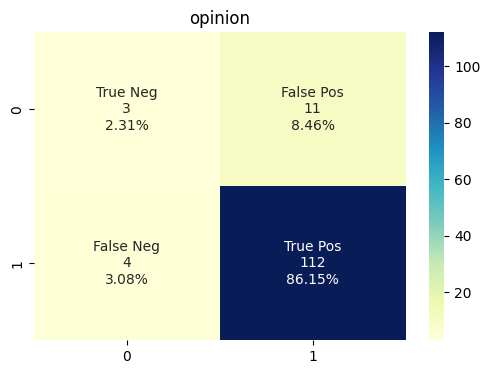

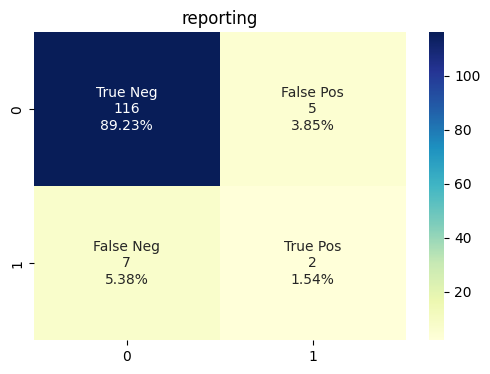

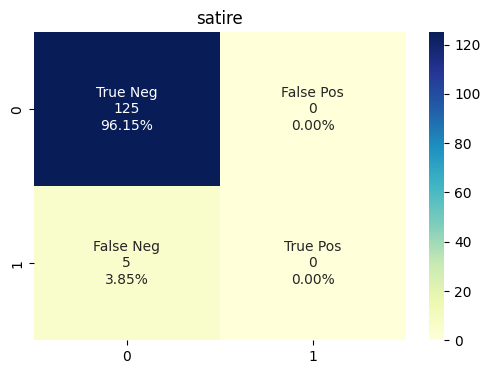

Random Forest metrics: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       116
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         5

    accuracy                           0.88       130
   macro avg       0.30      0.33      0.31       130
weighted avg       0.80      0.88      0.84       130



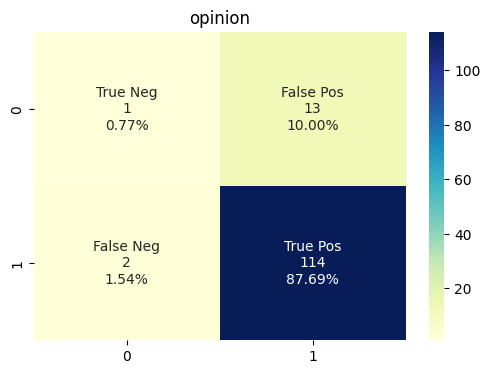

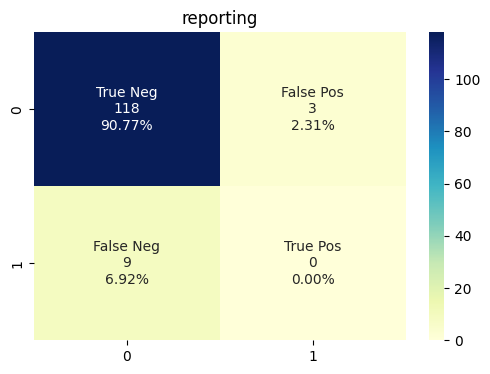

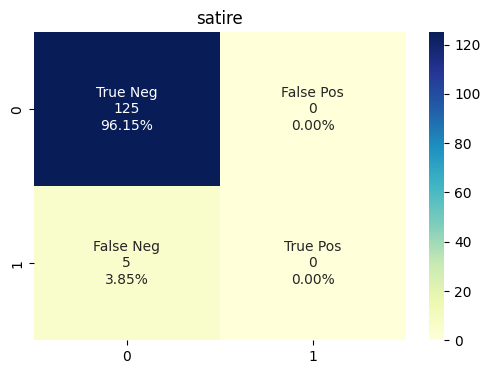

In [266]:
print("SVM metrics: ")
print(classification_report(labels_test,svc_pred, zero_division=0))
plt_confusion_matrix(labels_test,svc_pred)

print("Random Forest metrics: ")
print(classification_report(labels_test,rfc_pred, zero_division=0))
plt_confusion_matrix(labels_test,rfc_pred)


Complement Naive Bayes: 
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       116
           1       0.12      0.44      0.19         9
           2       0.33      0.20      0.25         5

    accuracy                           0.71       130
   macro avg       0.46      0.46      0.42       130
weighted avg       0.85      0.71      0.76       130



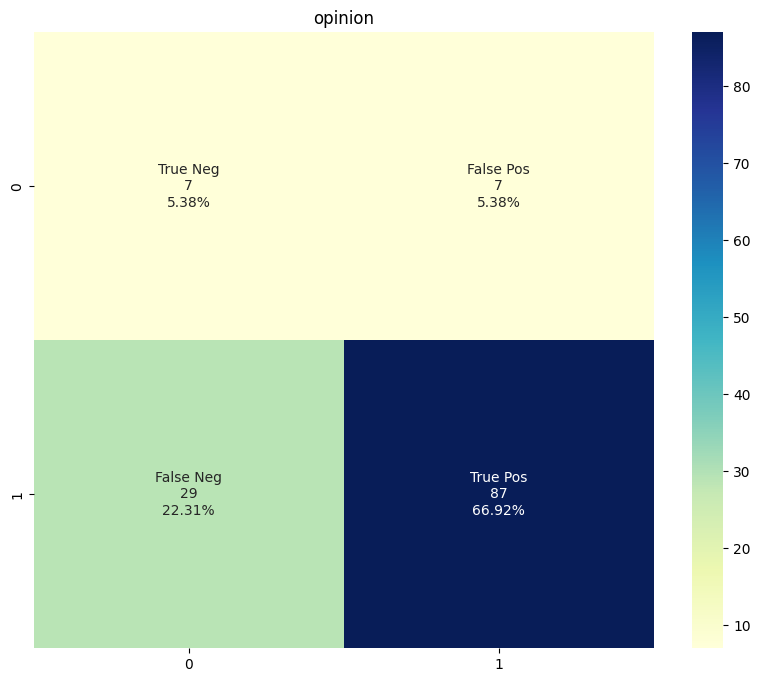

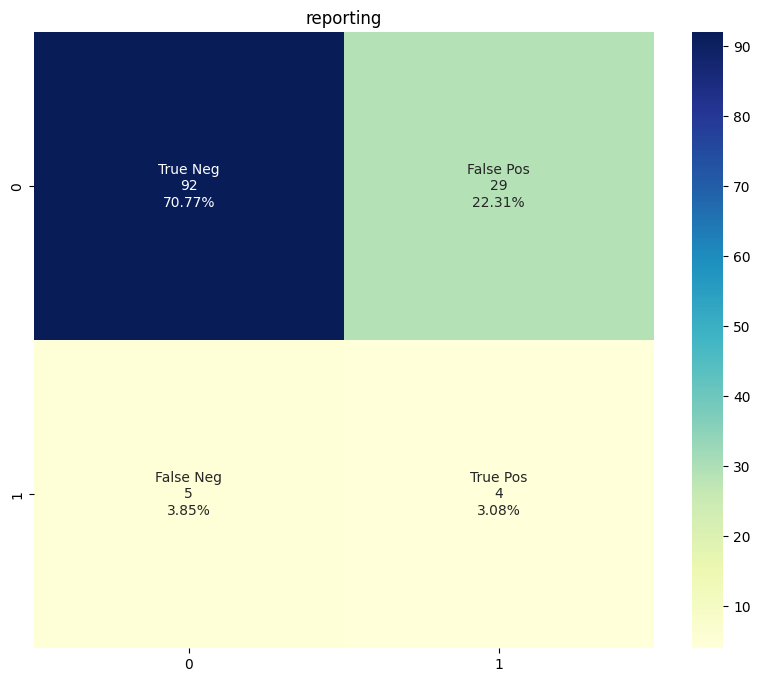

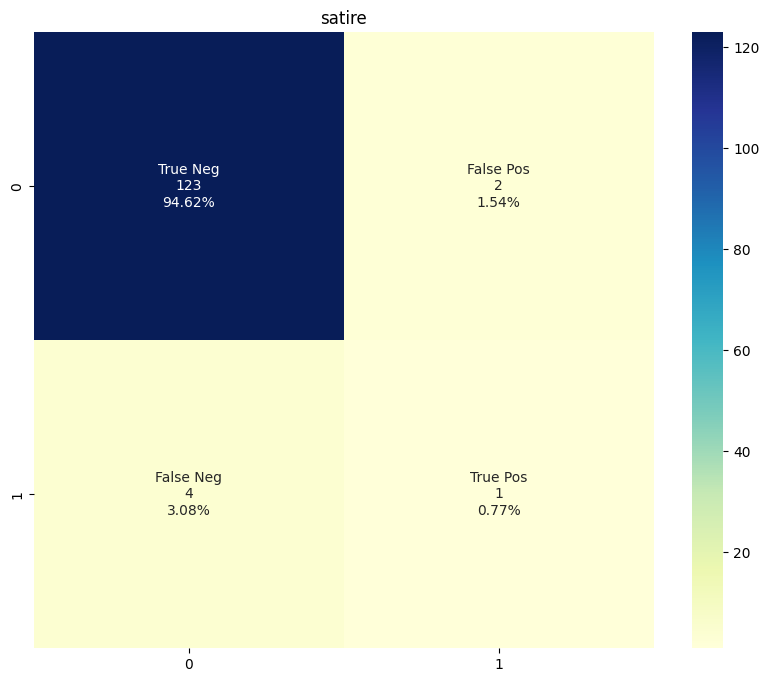

Multinomial Naive Bayes: 
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       116
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         5

    accuracy                           0.89       130
   macro avg       0.30      0.33      0.31       130
weighted avg       0.80      0.89      0.84       130



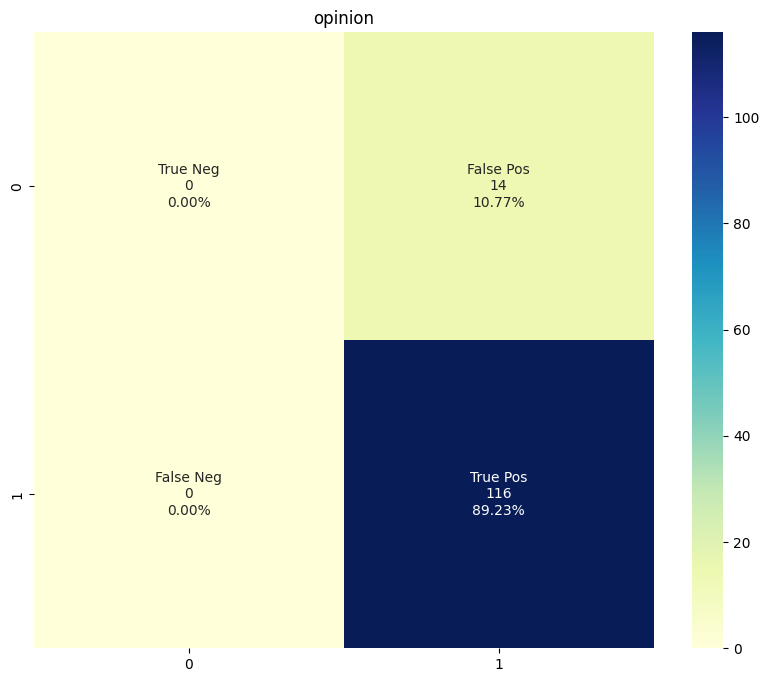

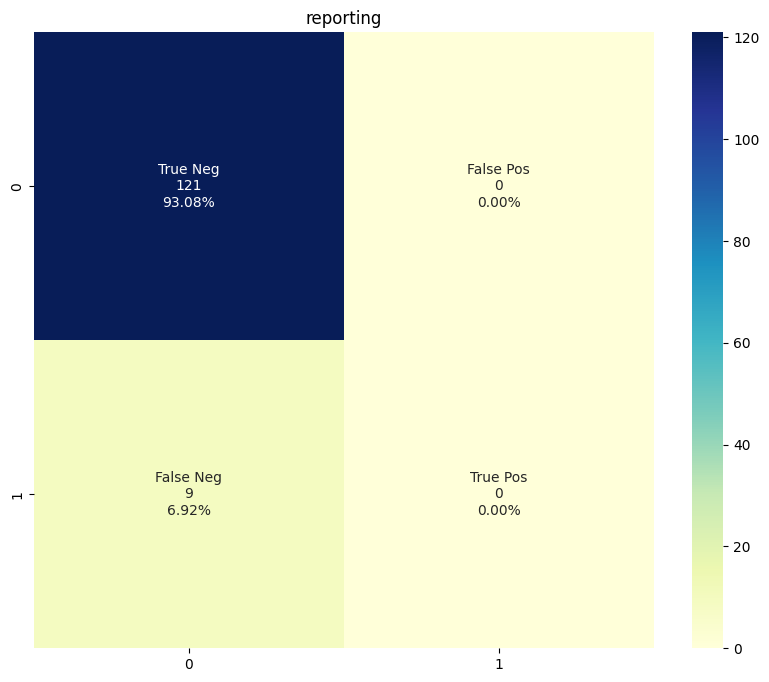

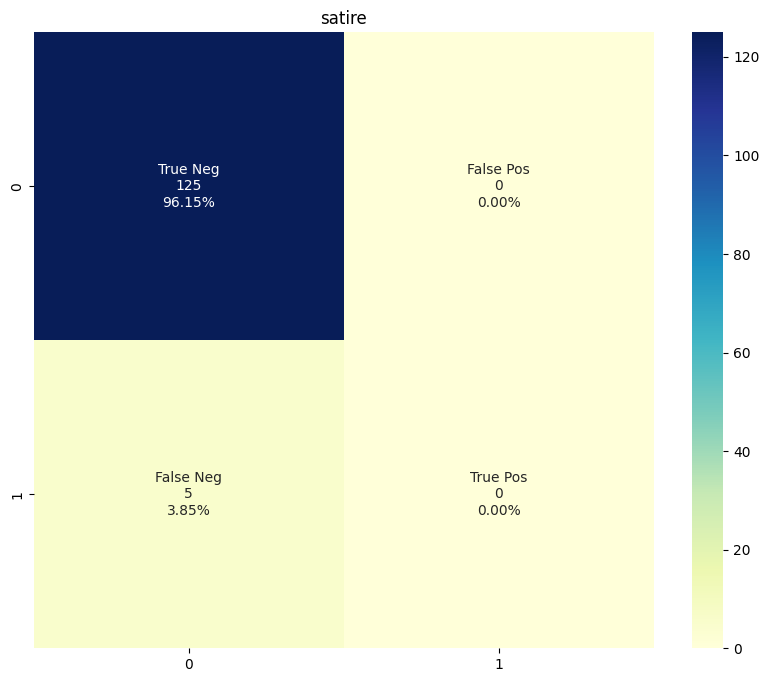

In [261]:

print("Complement Naive Bayes: ")
print(classification_report(labels_test,cnbc_pred, zero_division=0))
plt_confusion_matrix(labels_test,cnbc_pred)

print("Multinomial Naive Bayes: ")
print(classification_report(labels_test,mnbc_pred, zero_division=0))
plt_confusion_matrix(labels_test,mnbc_pred)